In [1]:
import numpy as np
from matplotlib import pylab as plt
from matplotlib import cm
plt.style.use('seaborn-paper')
#print(plt.style.available)

In [403]:
import utils
import plotting
import helper
import models
# Hack for reloading in notebooks without reseting the kernel
import importlib
importlib.reload(utils)
importlib.reload(helper)
importlib.reload(plotting)
importlib.reload(models)

from helper import *
from utils import *
from analytical_solutions import *

In [13]:
import torchdiffeq

In [3]:
device = get_device()
set_seed()

Using the CPU


In [319]:
## Deprecated ##
class RNN(torch.nn.Module):
    def __init__(self,dim,hidden=10):
        super(RNN,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim,hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden,dim),
        )
    def forward(self,x):
        return self.net(x)
class ResRNN(torch.nn.Module):
    def __init__(self,dim,hidden=10):
        super(RNN,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim,hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden,dim),
        )
    def forward(self,x):
        return x + self.net(x)

In [59]:
## Deprecated
class ODE_Func(torch.nn.Module):
    def __init__(self,dim,hidden=10):
        super(ODE_Func,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim,hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden,dim),
        )
    def forward(self,t,x):
        return self.net(x)

In [449]:
## TODO: Migrate out
def solve_and_plot(model, model_ts, data, data_ts=None, method='rk4', idcs=0):
    if data_ts is None:
        data_ts = model_ts
    with torch.no_grad():
        pred = torchdiffeq.odeint(model, data[0,:], model_ts, method=method)
    plt.plot(data_ts.cpu().numpy(), data.detach().cpu().numpy()[:,idcs], '--')
    plt.plot(model_ts.cpu().numpy(), pred.detach().cpu().numpy()[:,idcs])

In [507]:
ts_double = torch.linspace(0,t_max,N_time_step//2)
ts_half = torch.linspace(0,t_max,N_time_step*2)
def plot_3x3(model, data, idcs=slice(0,2)):
    plt.figure(figsize=(plotting.FIG_SIZE_FULL[0],plotting.FIG_SIZE_FULL[1]*3))
    plots = [('euler','Euler (trained on)'),
             ('midpoint','Midpoint (inference)'),
             ('rk4','RK4 (inference)')]
    ts_sets = [(ts_half,'Half $\Delta t$'), (torch_ts,'Trained $\Delta t$'), (ts_double, 'Twice $\Delta t')]
    for j,(tset,tlabel) in enumerate(ts_sets):
        for i,(method,title) in enumerate(plots):
            plt.subplot(3,3,1+3*j+i)
            plt.title(title)
            solve_and_plot(model,tset, data,torch_ts,method,idcs=idcs)
            if(i==0): plt.ylabel(tlabel+'\n x(t),y(t)')
            if(j==3-1): plt.xlabel('t')
    plt.tight_layout()

# Learning the pendulum in theta-space

Firstly, we make a dataset of the pendulum trajectory. The solution to the nonlinear pendulum is
\begin{equation}
\theta(t)=2\arcsin\left( \sin\frac{\theta_0}{2} \mathrm{sn}\left(K\left(\sin^2\frac{\theta_0}{2}\right)-\omega_0t \, ; \, \sin^2\frac{\theta_0}{2} \right)\right)
\end{equation}
where $K$ is the complete elliptic integral of the first kind, and $\mathrm{sn}$ is the Jacobi elliptic function of the first kind. The key identity to obtaining the rate of $\theta$ is $sn'(x)=x'cn(x)dn(x)$.
The angular frequency $\omega_0$ is 
\begin{equation}
\omega_0 = \sqrt{g/R}
\end{equation}

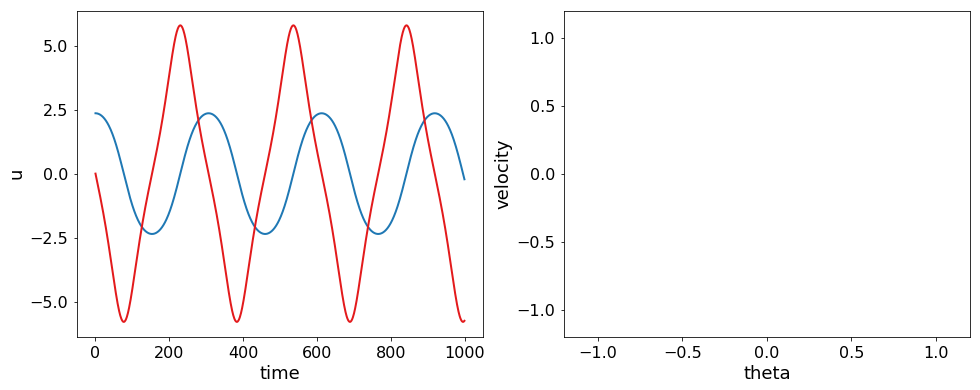

In [509]:
t_max = 10
N_time_step = 1000
dt = t_max/N_time_step
anal_ts = np.linspace(0,t_max,N_time_step)
data = solution_pendulum_theta(anal_ts, 1.5*np.pi/2)
plotting.trajectory_plots([data])
theta_ts = data_to_torch(anal_ts,device)#.reshape(-1,1)
theta_data = data_to_torch(data,device)#.reshape(-1,1,data.shape[-1])

Parameterized by the $\theta$, the pendulum obeys the law
\begin{equation}
\ddot{\theta} = g \sin(\theta)
\end{equation}
with a dummy variable $v=\dot{\theta}$. Below is an implementation of this rate:

In [510]:
class PendulumForceTheta(torch.nn.Module):
    def __init__(self):
        super(PendulumForceTheta,self).__init__()
    def forward(self,t, State):
        theta, v = State[:,0], State[:,1]
        g = -9.81
        return torch.stack([
            v,
            g*torch.sin(theta),
        ],dim=-1)

In [511]:
FTrue = PendulumForceTheta()

As a sanity check, we use this hand-coded "model" to solve with the known ode solvers to see the expected behavior. The explicit midpoint and RK4 do just fine on this method, but forward euler falls off of the attracter and starts to diverge.

(-6, 6)

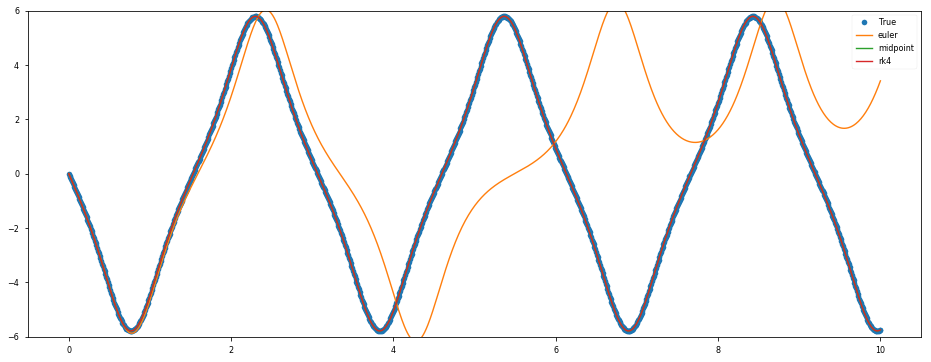

In [513]:
plt.figure(figsize=plotting.FIG_SIZE_FULL)
plt.plot(anal_ts,data[:,1],'o',label='True')
with torch.no_grad():
    for m in ['euler','midpoint','rk4']:#,'dopri5']:
        pred = torchdiffeq.odeint(FTrue, theta_data[0:1,:], theta_ts, method=m)
        plt.plot(theta_ts.cpu().numpy(),pred.detach().cpu().numpy().reshape(-1,2)[:,1],label=m)
plt.legend()
plt.ylim(-6,6)

## These are the representative models

In [515]:
rnn = models.ShallowNet(2,2,50).double().to(device)
skiprnn = models.ShallowSkipNet(2,50).double().to(device)
ode_neural = models.ShallowODE(2,50).double().to(device)
ode_multi = models.ShallowODE(2,50).double().to(device)

First, we try the NN types

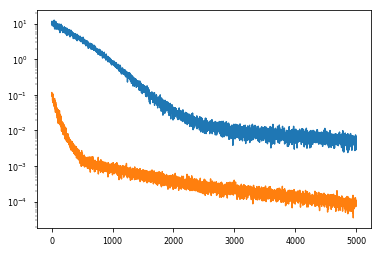

In [517]:
_,losses = learn_rnn(theta_data, rnn, device=device, N_iter=5000)
plt.semilogy(losses)
_,losses = learn_rnn(theta_data, skiprnn, device=device, N_iter=5000)
plt.semilogy(losses)

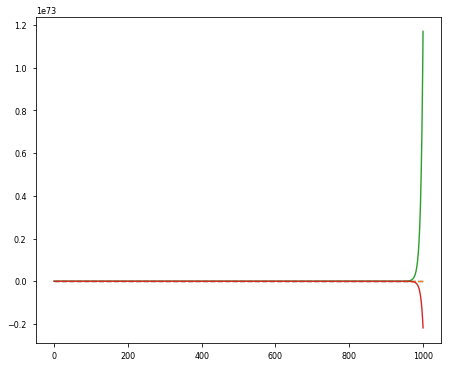

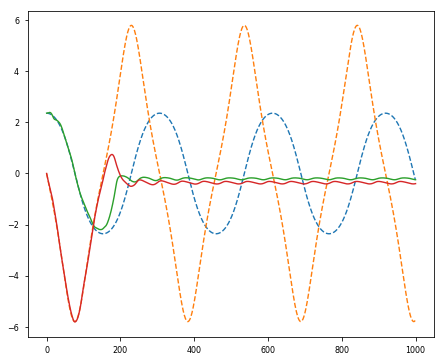

In [520]:
plt.figure(figsize=plotting.FIG_SIZE_FULL)
y0 = theta_data[0:1,:]#data_to_torch([2.5,0],device=device)
ys_rnn = integrate_model(rnn,y0, 1000)
ys_resrnn = integrate_model(skiprnn,y0, 1000)
def plotem(ys):
    plt.subplot(1,2,1)
    plt.plot(data,'--')
    plt.plot(ys[:,0])
    plt.plot(ys[:,1])
plotem(ys_rnn)
plt.figure(figsize=plotting.FIG_SIZE_FULL)
plotem(ys_resrnn)

Next, we try the neural ODE, which learns a nonlinear function embedded inside of an ode solver.

In [521]:
def train_a_neural_ode(data, ts, model=None, batch_size=25, n_future=1, 
                       learning_rate = 1.0e-4, N_iter = 50000,
                       verbose=False, device=None, method='euler'):
    if device is None:
        device = get_device()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    N_print, N_trace = N_iter, 100
    for itr in range(1, N_iter):
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch(data, ts,
                                               batch_size, n_future) # TODO BUG
        pred_y = torchdiffeq.odeint(model, batch_y0, batch_t,
                                    method=method)
        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().numpy())
        if itr % 1000 == 0:
            with torch.no_grad():
                pred_y = torchdiffeq.odeint(model, batch_y0, batch_t)
                loss = torch.mean(torch.abs(pred_y - batch_y))
    return model,np.array(losses)

In [522]:
_,losses = train_a_neural_ode(theta_data, theta_ts, ode_neural)
plt.semilogy(losses)

Using the CPU


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

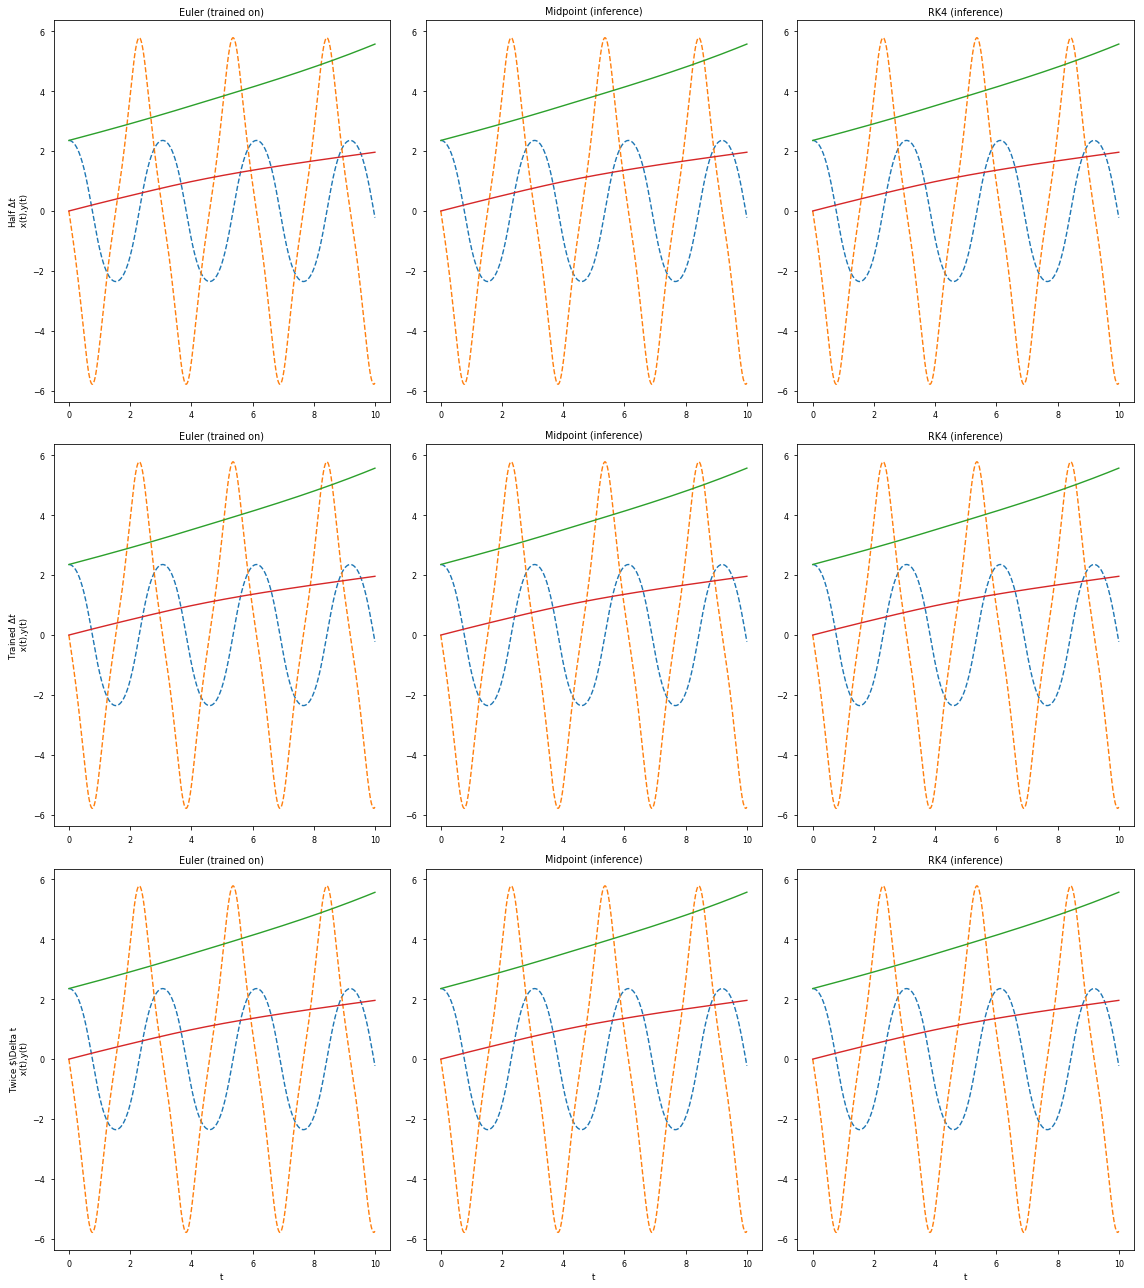

In [523]:
plot_3x3(ode_neural, theta_data)

In [428]:
def train_a_neural_ode_multi_method(data, ts, model=None, batch_size=25, n_future=1, 
                       learning_rate = 1.0e-4, weight_decay = 1e-5,
                       verbose=False, device=None, methods=('euler','midpoint','rk4')):
    if device is None:
        device = get_device()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                weight_decay=weight_decay)
    losses = []
    N_iter = 50000
    N_print, N_trace = N_iter, 100
    for itr in range(1, N_iter):
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch(data, ts,
                                               batch_size, n_future+1)
        
        pred_y = torchdiffeq.odeint(model, batch_y0, batch_t,
                                    method=methods[0])
        loss = torch.mean(torch.abs(pred_y - batch_y))
        for met in methods[1:]:
            pred_y = torchdiffeq.odeint(model, batch_y0, batch_t,
                                    method=met)
            loss += torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().numpy())
        if itr % 1000 == 0:
            with torch.no_grad():
                pred_y = torchdiffeq.odeint(model, batch_y0, batch_t)
                loss = torch.mean(torch.abs(pred_y - batch_y))
    return model,np.array(losses)

Finally, we show our approach, which uses multiple ODE solvers to force it not overfit.

In [524]:
train_a_neural_ode_multi_method(theta_data, theta_ts, ode_multi)

Using the CPU


(ShallowODE(
   (net): Sequential(
     (0): Linear(in_features=2, out_features=50, bias=True)
     (1): ReLU()
     (2): Linear(in_features=50, out_features=2, bias=True)
   )
 ), array([0.08482562, 0.083387  , 0.0805445 , ..., 0.00042535, 0.00041271,
        0.00039062]))

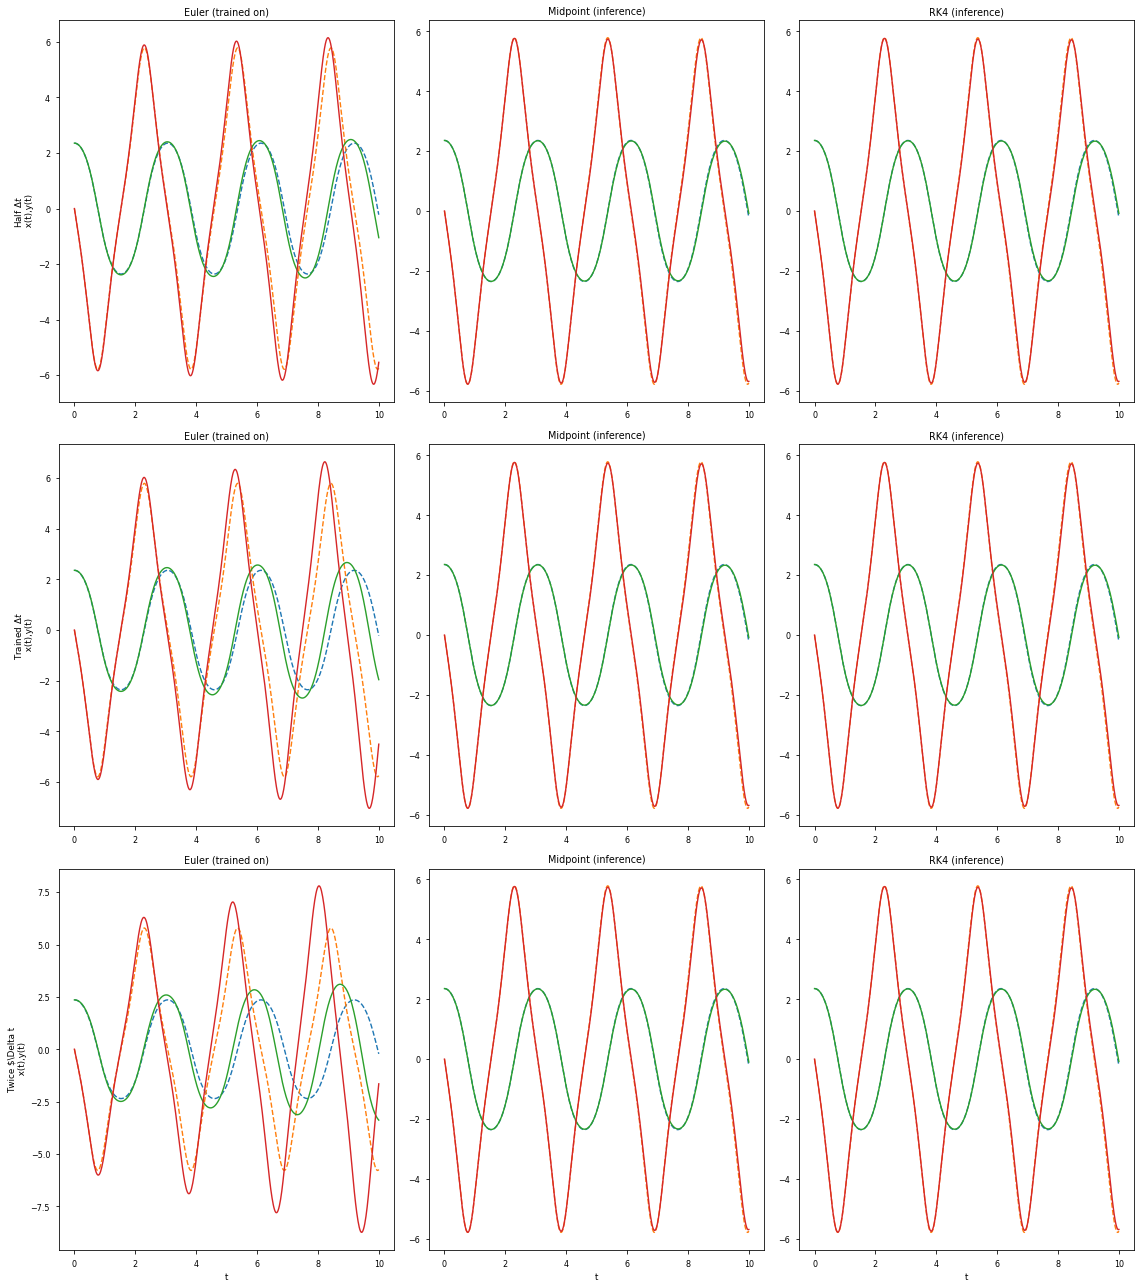

In [525]:
plot_3x3(ode_multi, theta_data)

# Learning the pendulum in xy space

Now, we sovle the same exact problem as above, but in a cartesian space. This makes the problem "more nonlinear", and adds a constraint to it. There are now four degrees of freedom, as opposed to two.

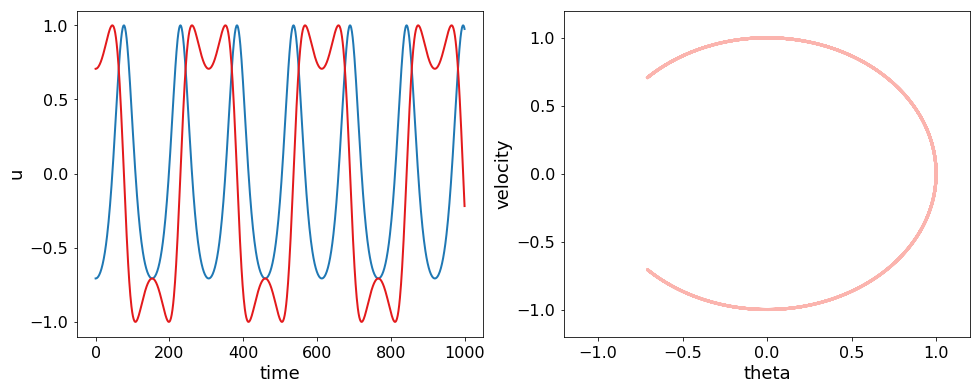

In [426]:
t_max = 10
N_time_step = 1000
dt = t_max/N_time_step
anal_ts = np.linspace(0,t_max,N_time_step)
data = solution_pendulum_xy(anal_ts, 1.5*np.pi/2)
plotting.trajectory_plots([data])

In [427]:
torch_ts = data_to_torch(anal_ts,device)#.reshape(-1,1)
torch_data = data_to_torch(data,device)#.reshape(-1,1,data.shape[-1])

## Solve it with an known ODE formula

We have older and trusted libraries for integrating odes, but using torchdiffeq just holds all things equal. The constraint force $f$ is derived from the formula $v\cdot n = 0$ which implies $\dot{\overline{v\cdot n}}=a\cdot n + v\cdot v=0$, yielding,
\begin{equation}
f = v\cdot v + g\cdot n
\end{equation}
Because of the constraint, this becomes a stiff equation.

In [364]:
class PendulumForceXY(torch.nn.Module):
    def __init__(self):
        super(PendulumForceXY,self).__init__()
    def forward(self,t, State):
        x,y,vx,vy = State[:,0], State[:,1], State[:,2], State[:,3]
        nx, ny = -x, -y
        gx, gy = -9.81, 0
        f = (vx*vx + vy*vy) + (gx*nx + gy*ny)
        return torch.stack([
            vx,
            vy,
            f*nx-gx,
            f*ny-gy,
        ],dim=-1)

In [352]:
FTrue = PendulumForceXY()

(-2, 2)

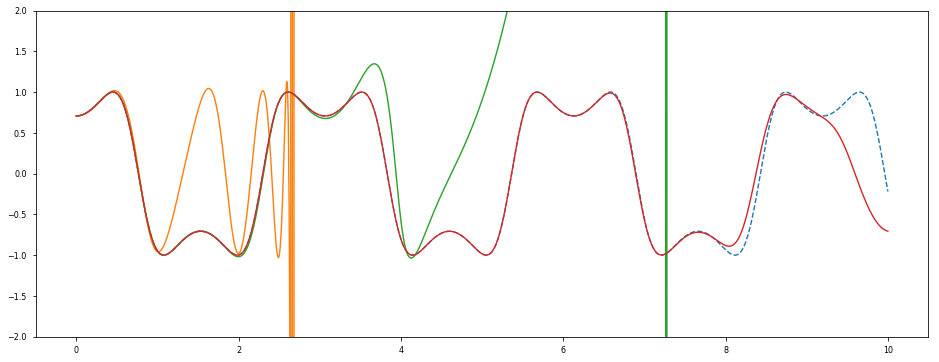

In [354]:
plt.figure(figsize=plotting.FIG_SIZE_FULL)
plt.plot(anal_ts,data[:,1],'--')
with torch.no_grad():
    for m in ['euler','midpoint','rk4']:#,'dopri5']:
        pred = torchdiffeq.odeint(FTrue, torch_data[0:1,:], torch_ts, method=m)
        plt.plot(anal_ts,pred.detach().cpu().numpy().reshape(-1,4)[:,1:2])
plt.ylim(-2,2)

Note how the traditional ODE solvers don't do a very good job with this stiff formulation. This is well understood, even though we had hoped for a little better.

## Learn a discrete RNN

Using the CPU


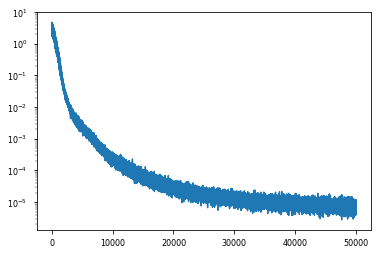

In [321]:
model_rnn = RNN(4,hidden=50).double()
_,losses = learn_rnn(torch_data, model_rnn, N_iter=50000)
plt.semilogy(losses)

Using the CPU


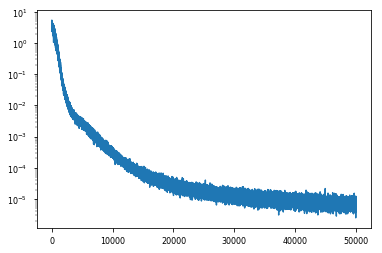

In [320]:
model_resrnn = RNN(4,hidden=50).double()
_,losses = learn_rnn(torch_data, model_resrnn, N_iter=50000)
plt.semilogy(losses)

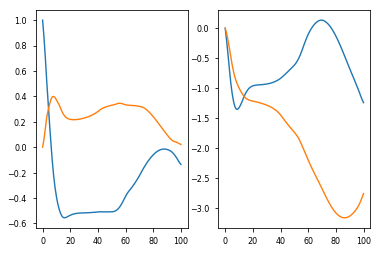

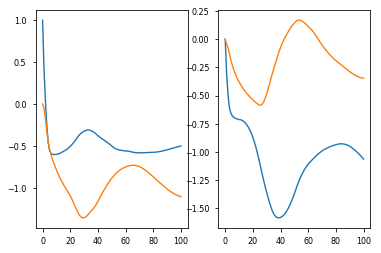

In [363]:
y0 = data_to_torch([1,0,0,0],device=device)
ys_rnn = integrate_model(model_rnn,y0, 100)
ys_resrnn = integrate_model(model_resrnn,y0, 100)
def plotem(ys):
    plt.subplot(1,2,1)
    plt.plot(ys[:,0])
    plt.plot(ys[:,1])
    plt.subplot(1,2,2)
    plt.plot(ys[:,2])
    plt.plot(ys[:,3])
plotem(ys_rnn)
plt.figure()
plotem(ys_resrnn)

## Learn a Neural ODE

In [136]:
model_neuralode=ODE_Func(4, hidden=50).double().to(device)

In [137]:
model_neuralode,losses = train_a_neural_ode(torch_data,torch_ts, model=model_neuralode, device=device, batch_size=25, method='euler')

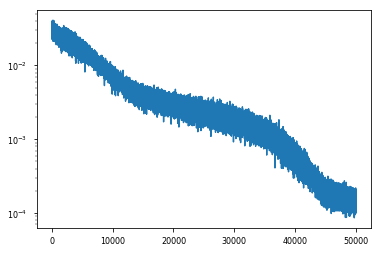

In [138]:
plt.semilogy(losses)

In [494]:
ts_double = torch.linspace(0,t_max,N_time_step//2)
ts_half = torch.linspace(0,t_max,N_time_step*2)
def plot_3x3(model, idcs=slice(0,2)):
    plt.figure(figsize=(plotting.FIG_SIZE_FULL[0],plotting.FIG_SIZE_FULL[1]*3))
    plots = [('euler','Euler (trained on)'),
             ('midpoint','Midpoint (inference)'),
             ('rk4','RK4 (inference)')]
    ts_sets = [(ts_half,'Half $\Delta t$'), (torch_ts,'Trained $\Delta t$'), (ts_double, 'Twice $\Delta t')]
    for j,(tset,tlabel) in enumerate(ts_sets):
        for i,(method,title) in enumerate(plots):
            plt.subplot(3,3,1+3*j+i)
            plt.title(title)
            solve_and_plot(model,tset, torch_data,torch_ts,method,idcs=idcs)
            if(i==0): plt.ylabel(tlabel+'\n x(t),y(t)')
            if(j==3-1): plt.xlabel('t')
    plt.tight_layout()

In [495]:
!mkdir plots

mkdir: plots: File exists


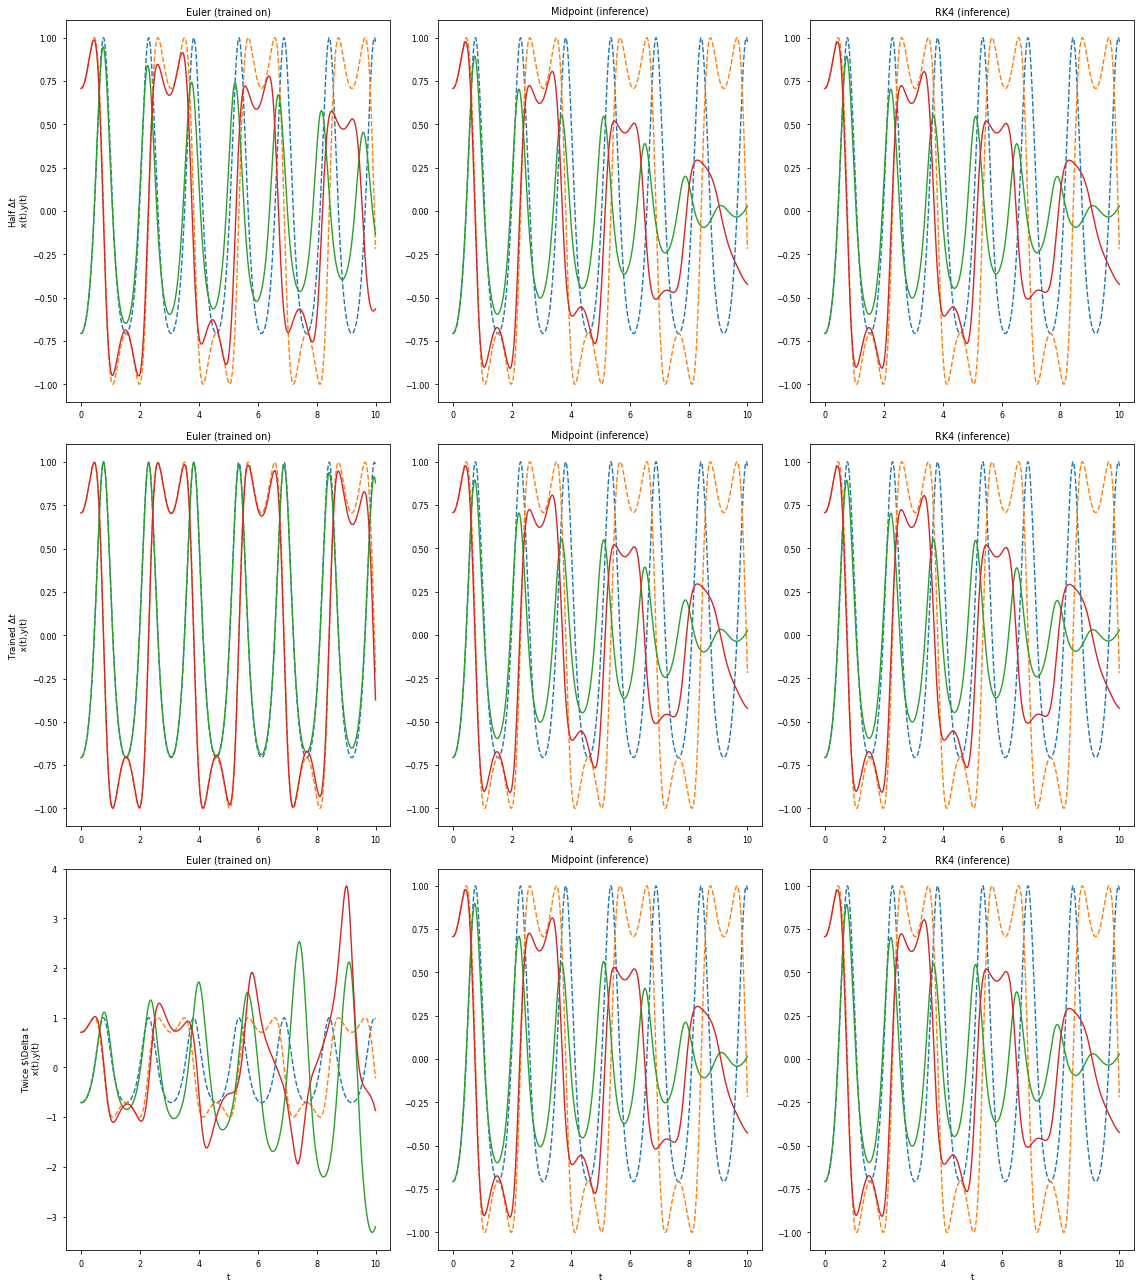

In [496]:
plot_3x3(model_neuralode)
plt.savefig('plots/pend_xy_ode.png')

## Correctly learn the dynamics

In [429]:
model_multi=ODE_Func(4, hidden=50).double()

In [430]:
model_multi,losses = train_a_neural_ode_multi_method(torch_data,torch_ts, model=model_multi, device=device, batch_size=25)

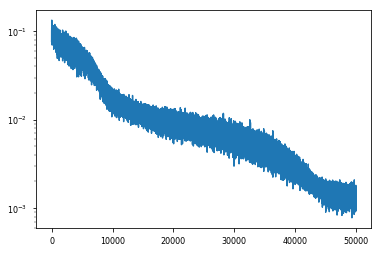

In [431]:
plt.semilogy(losses)

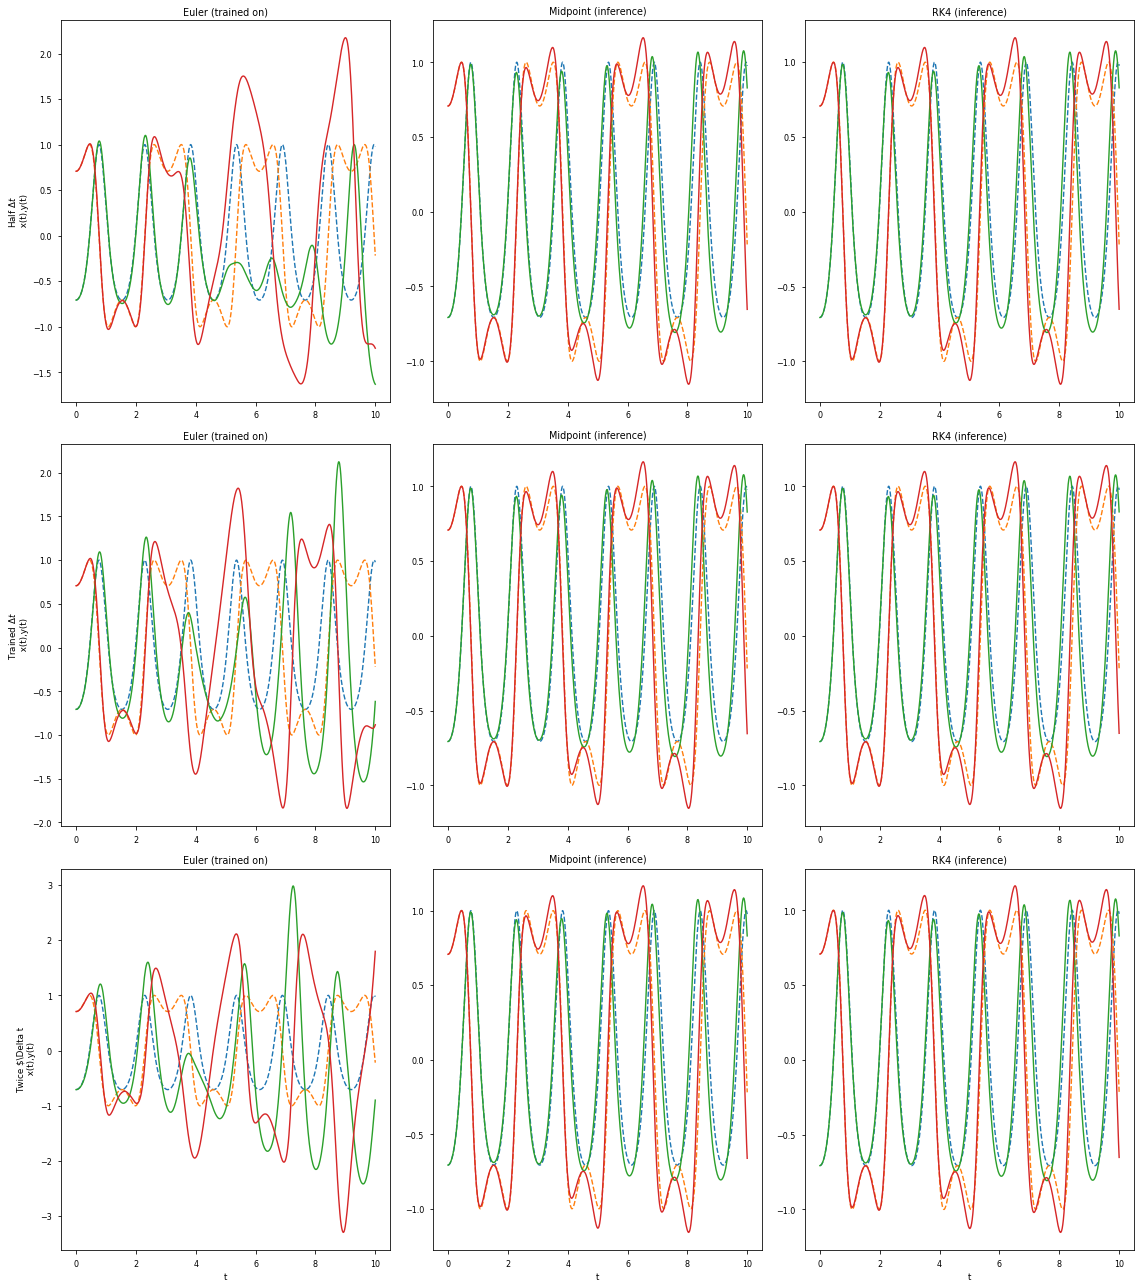

In [497]:
plot_3x3(model_multi)
plt.savefig('plots/pend_xy_multiode.png')

# Compare the results

In [350]:
ys = [ [0,1,0,0], [1,0,0,0], [np.sqrt(2),np.sqrt(2),0,0], [np.sqrt(2),-np.sqrt(2),0,0],  ]
for y in ys:
    y = data_to_torch([y],device=device)
    print(FTrue(0,y).detach().numpy())
    print(model_multi(0,y).detach().numpy())
    print(model_neuralode(0,y).detach().numpy())
    print()

[[ 0.    0.    9.81 -0.  ]]
[[ 0.07372961 -0.04148617 -1.42552288 -8.84952317]]
[[ 0.26111053 -0.2223282  -2.27534087 -9.0609527 ]]

[[ 0.  0.  0. -0.]]
[[  0.0982639   -0.30855737 -25.23486519  -2.24264651]]
[[  0.26319153  -0.25931616 -24.60033476  -2.04107228]]

[[  0.     0.    -9.81 -19.62]]
[[  0.15091852  -0.28507536 -37.16552464 -40.92386593]]
[[  0.54601815  -0.54505144 -36.56608475 -35.23111053]]

[[ 0.    0.   -9.81 19.62]]
[[  0.19424951  -0.24537617 -35.91966468  33.04618353]]
[[  0.13691394   0.39780846 -34.77603909  31.10221374]]

